# RRT Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import random

In [35]:
# Define the parameters of the RRT implementation
xdim=10
ydim=10
epsilon=1.0      # Max length of branch
numNodes=1000
goal_region=0.35   
div=20

init_node=(2,2)
fin_node=(8,8)

In [5]:
# Define functions for RRT

#Find the distance between
def dist(p1,p2):
    d=np.sqrt((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)
    return d

# If the edge between two points are longer than epsilon, shorten the edge to match epsilon.
# p2 is the newly sampled random point
def set_edge_pt(p1,p2):
    d=dist(p1,p2)
    if d<epsilon:
        return p2
    else:
        new_pt=((p2[0]-p1[0])/d*epsilon+p1[0],(p2[1]-p1[1])/d*epsilon+p1[1])
        return new_pt

### An implementation of RRT in 2D with no obstacles

Number of nodes: 292


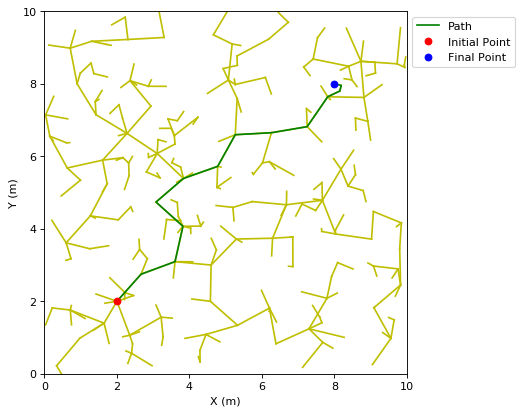

In [12]:
# Initialize the figure
fig=plt.figure(figsize=(8.333,6),dpi=80)
ax=fig.add_subplot(111,autoscale_on=False, xlim=(0, xdim), ylim=(0, ydim))
ax.set_aspect('equal')

# Initialize a list of nodes and edges
nodes=[]
nodes.append(init_node)
E=[]

for i in range(numNodes):
    node=nodes[0]
    rand_pt=(random.random()*xdim, random.random()*ydim)
    for p in nodes:
        if dist(p,rand_pt)<dist(node,rand_pt):
            node=p
    new_rand_pt=set_edge_pt(node,rand_pt)
    nodes.append(new_rand_pt)
    E.append((node,new_rand_pt))
    ax.plot([node[0], new_rand_pt[0]],[node[1], new_rand_pt[1]],'y-')
    if dist(new_rand_pt,fin_node)<goal_region:
        break
        
path=[]
path.append(fin_node)
path.append(E[-1][1])
path.append(E[-1][0])
current_node=E[-1][0]
while current_node!=init_node:
    for e in E:
        if e[1]==current_node:
            path.append(e[0])
            current_node=e[0]
path.reverse()

# Plot the final path
ax.plot([path_x[0] for path_x in path],[path_y[1] for path_y in path],'g-',label='Path')


print('Number of nodes: '+str(i))
        
# Plot the initial and final points
ax.plot(init_node[0],init_node[1],'ro',label='Initial Point')
ax.plot(fin_node[0],fin_node[1],'bo',label='Final Point')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.legend(bbox_to_anchor=(1,1))
plt.show()

## An implementation of RRT in 2D with obstacles 

In [14]:
# Create a class for obstacles that are square
class Obstacle:
    def __init__(self,center,angle,length):
        self.center=(center[0],center[1])
        self.ang=angle                       # Angle in rads, positive direction CCW from +x axis
        self.length=length
        corner_length=np.sqrt(2)*self.length/2
        cos_val=np.cos(self.ang+np.pi/4)*corner_length
        sin_val=np.sin(self.ang+np.pi/4)*corner_length
        self.corner=np.array([[cos_val+self.center[0],sin_val+self.center[1]],
                              [-sin_val+self.center[0],cos_val+self.center[1]],
                              [-cos_val+self.center[0],-sin_val+self.center[1]],
                              [sin_val+self.center[0],-cos_val+self.center[1]],
                              [cos_val+self.center[0],sin_val+self.center[1]]])

# Create two square obstacles
obs1=Obstacle((5,5),-np.pi/8,1.5)
obs2=Obstacle((4.5,2.5),np.pi/4,1.5)

In [15]:
# Check collision of the point with an obstacle
def collision(obs,pt):
    box_to_pt=np.array([pt[0]-obs.center[0],pt[1]-obs.center[1]])
    box_to_pt_norm=box_to_pt/np.linalg.norm(box_to_pt)
    max_val=float("-inf")
    for i in range(4):
        obs_pt=obs.corner[i,:]
        v=np.array([obs_pt[0]-obs.center[0],obs_pt[1]-obs.center[1]])
        current_proj=np.matmul(v,box_to_pt_norm)
        if max_val<current_proj:
            max_val=current_proj
    if np.linalg.norm(box_to_pt)-max_val>0:
        return False
    return True

Number of nodes: 555


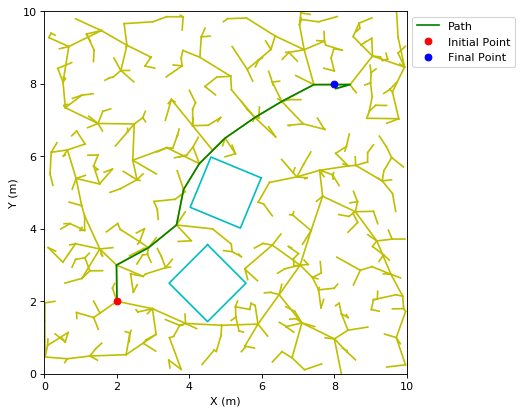

In [52]:
# Initialize the figure
fig=plt.figure(figsize=(8.333,6),dpi=80)
ax=fig.add_subplot(111,autoscale_on=False, xlim=(0, xdim), ylim=(0, ydim))
ax.set_aspect('equal')

# Initialize a list of nodes and edges
nodes=[]
nodes.append(init_node)
E=[]

# Create the random tree
for i in range(numNodes):
    node=nodes[0]
    rand_pt=(random.random()*xdim, random.random()*ydim)
    for p in nodes:
        if dist(p,rand_pt)<dist(node,rand_pt):
            node=p
    new_rand_pt=set_edge_pt(node,rand_pt)
    if not collision(obs1,new_rand_pt) and not collision(obs2,new_rand_pt):
        intersect=False
        for j in range(div):
            line_point=((j/div)*node[0]+(1-j/div)*new_rand_pt[0],(j/div)*node[1]+(1-j/div)*new_rand_pt[1])
            if collision(obs1,line_point) or collision(obs2,line_point):
                intersect=True
                break
        if not intersect:
            nodes.append(new_rand_pt)
            E.append((node,new_rand_pt))
            ax.plot([node[0], new_rand_pt[0]],[node[1], new_rand_pt[1]],'y-')
            if dist(new_rand_pt,np.array(fin_node))<goal_region:
                break

# If the last node isn't in the goal region, the algorithm failed to find a path 
if dist(E[-1][1],fin_node)>goal_region:
    print("Failed to find path")
else:
    # Find the path
    path=[]
    path.append(fin_node)
    path.append(E[-1][1])
    path.append(E[-1][0])
    current_node=E[-1][0]
    while current_node!=init_node:
        for e in E:
            if e[1]==current_node:
                path.append(e[0])
                current_node=e[0]
    path.reverse()

    # Plot the final path
    ax.plot([path_x[0] for path_x in path],[path_y[1] for path_y in path],'g-',label='Path')

# Plot the obstacles
ax.plot([obs[0] for obs in obs1.corner],[obs[1] for obs in obs1.corner],'c-',
        [obs[0] for obs in obs2.corner],[obs[1] for obs in obs2.corner],'c-')

print('Number of nodes: '+str(i+1))
        
# Plot the initial and final points
ax.plot(init_node[0],init_node[1],'ro',label='Initial Point')
ax.plot(fin_node[0],fin_node[1],'bo',label='Final Point')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()